In [1]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,Activation
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
im_shape = (200,200)

TRAINING_DIR = 'D:\input'
TEST_DIR = 'D:\input'
VAL_DIR = 'D:\input'

seed = 10
BATCH_SIZE = 16

In [3]:
# data_generator = ImageDataGenerator(
#        validation_split=0.2, rotation_range=5, width_shift_range=0.05,
#        height_shift_range=0.05, preprocessing_function=preprocess_input,
#        zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

# Image dataset 
# Without augmentation
data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [4]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(VAL_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 618 images belonging to 4 classes.
Found 153 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


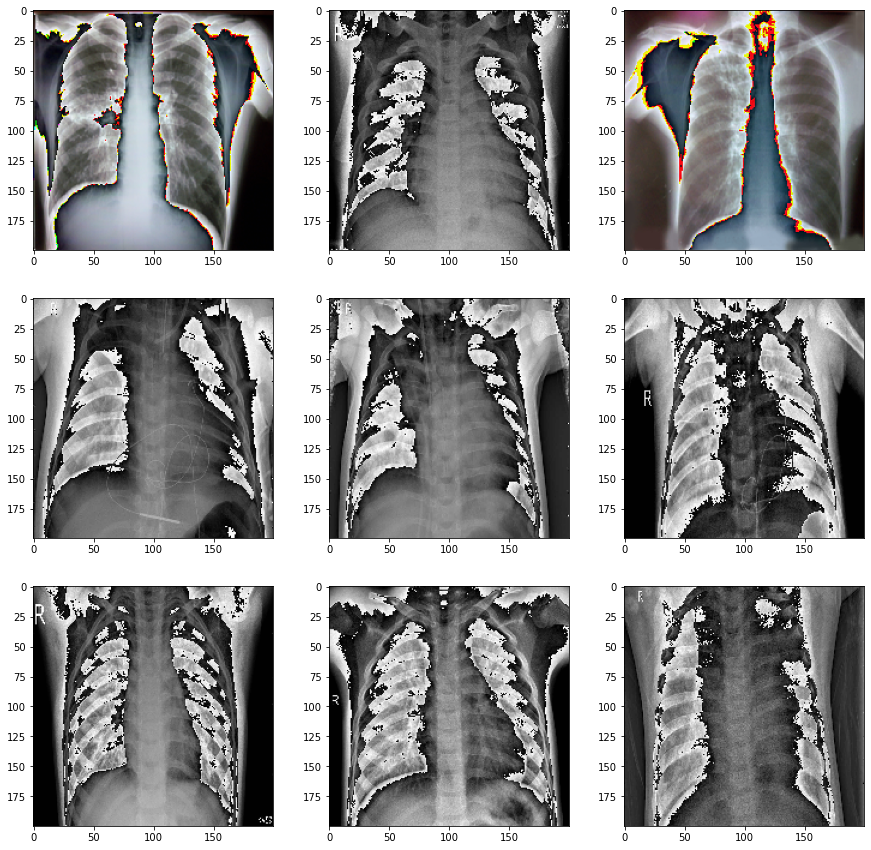

In [5]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [6]:
modelcnn = Sequential()
modelcnn.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(im_shape[0],im_shape[1],3)))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Dropout(0.2))
modelcnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Flatten())
modelcnn.add(Dense(100, activation='relu'))
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(num_classes, activation='softmax'))
modelcnn.summary()

modelcnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        1

In [7]:
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelcnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1)
]

#Training
history = modelcnn.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 1.0342 - accuracy: 0.5797
Epoch 1: val_loss improved from inf to 0.67899, saving model to modelcnn.h5
38/38 [==============================] - 42s 1s/step - loss: 1.0342 - accuracy: 0.5797 - val_loss: 0.6790 - val_accuracy: 0.7708
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8272
Epoch 2: val_loss improved from 0.67899 to 0.47374, saving model to modelcnn.h5
38/38 [==============================] - 32s 846ms/step - loss: 0.4189 - accuracy: 0.8272 - val_loss: 0.4737 - val_accuracy: 0.8194
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.8987
Epoch 3: val_loss did not improve from 0.47374
38/38 [==============================] - 28s 744ms/step - loss: 0.2939 - accuracy: 0.8987 - val_loss: 0.5391 - val_accuracy: 0.8056
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8887
Epoch 4: val_loss improved f

In [8]:
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [9]:
# Load the best saved model
from tensorflow.keras.models import load_model

#model = load_model('../input/classify-food-datas-models/model.h5')
#modelcnn = load_model('modelcnn.h5')
score = modelcnn.evaluate_generator(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\n\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = modelcnn.evaluate_generator(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])



Val loss: 0.3401727080345154
Val accuracy: 0.915032684803009

Test loss: 0.08386993408203125
Test accuracy: 0.9818417429924011


In [10]:
import itertools
#Gera matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report
               precision    recall  f1-score   support

      COVID19       0.95      0.99      0.97       106
       NORMAL       0.99      0.96      0.98       234
    PNEUMONIA       0.99      0.99      0.99       390
TURBERCULOSIS       0.97      0.95      0.96        41

     accuracy                           0.98       771
    macro avg       0.97      0.97      0.97       771
 weighted avg       0.98      0.98      0.98       771



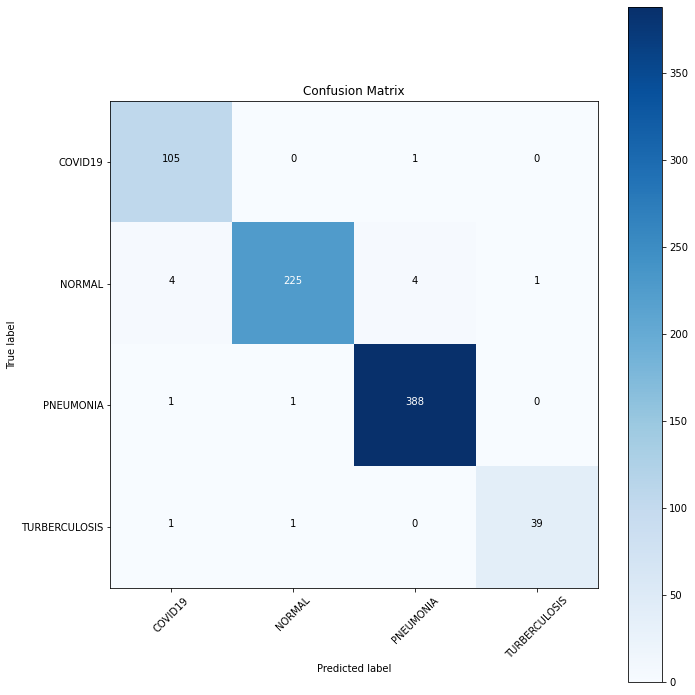

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = modelcnn.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Transfer Learning

In [12]:
# data_generator = ImageDataGenerator(
#        validation_split=0.2, rotation_range=5, width_shift_range=0.05,
#        height_shift_range=0.05, preprocessing_function=preprocess_input,
#        shear_range=0.05,
#        zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

# Image dataset 
# Without augmentation
data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator( preprocessing_function=preprocess_input,validation_split=0.2)

In [13]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(VAL_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 618 images belonging to 4 classes.
Found 153 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


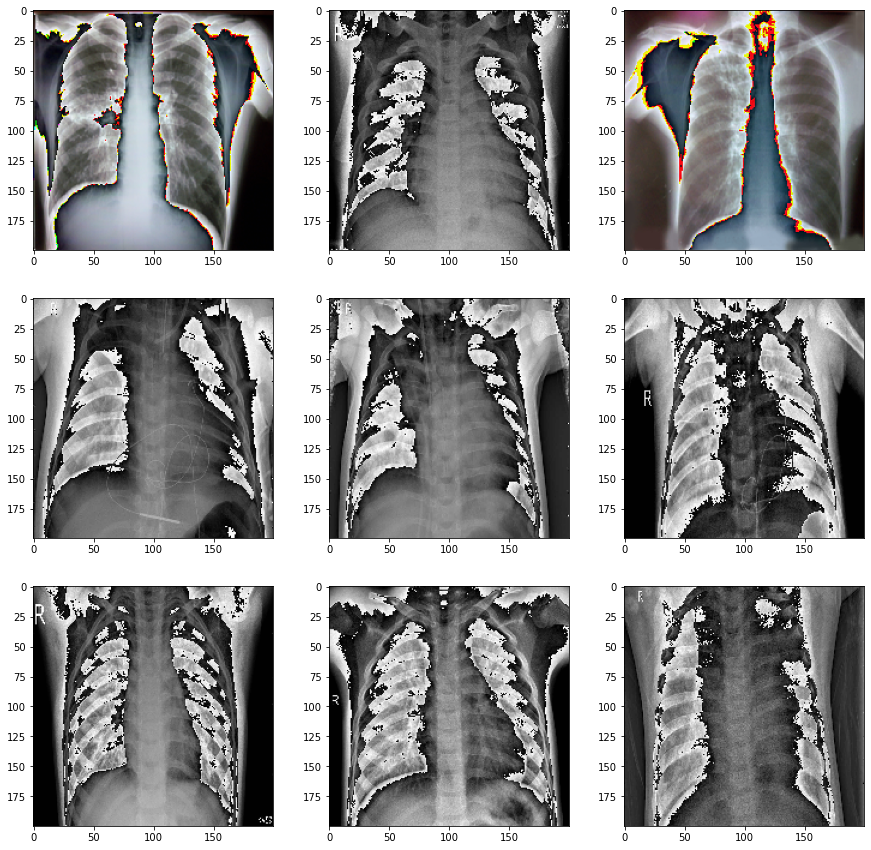

In [14]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [15]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(120, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

modeltrf = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
modeltrf.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

219070464/219055592 [==============================] - 61s 0us/step


In [16]:
epochs = 10

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modeltrf.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = modeltrf.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 2.0490 - accuracy: 0.6761
Epoch 1: val_loss improved from inf to 0.23592, saving model to modeltrf.h5
38/38 [==============================] - 145s 3s/step - loss: 2.0490 - accuracy: 0.6761 - val_loss: 0.2359 - val_accuracy: 0.9236
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9086
Epoch 2: val_loss improved from 0.23592 to 0.19689, saving model to modeltrf.h5
38/38 [==============================] - 122s 3s/step - loss: 0.2326 - accuracy: 0.9086 - val_loss: 0.1969 - val_accuracy: 0.9236
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9203
Epoch 3: val_loss did not improve from 0.19689
38/38 [==============================] - 106s 3s/step - loss: 0.1861 - accuracy: 0.9203 - val_loss: 0.5479 - val_accuracy: 0.7847
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9236
Epoch 4: val_loss improved from

In [17]:
# Using the validation dataset
score = modeltrf.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.2424212247133255
Val accuracy: 0.915032684803009


In [18]:
# Using the test dataset
score = modeltrf.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05389256775379181
Test accuracy: 0.9831387996673584


Classification Report
               precision    recall  f1-score   support

      COVID19       0.95      0.99      0.97       106
       NORMAL       0.98      0.97      0.98       234
    PNEUMONIA       0.99      0.99      0.99       390
TURBERCULOSIS       1.00      0.95      0.97        41

     accuracy                           0.98       771
    macro avg       0.98      0.98      0.98       771
 weighted avg       0.98      0.98      0.98       771



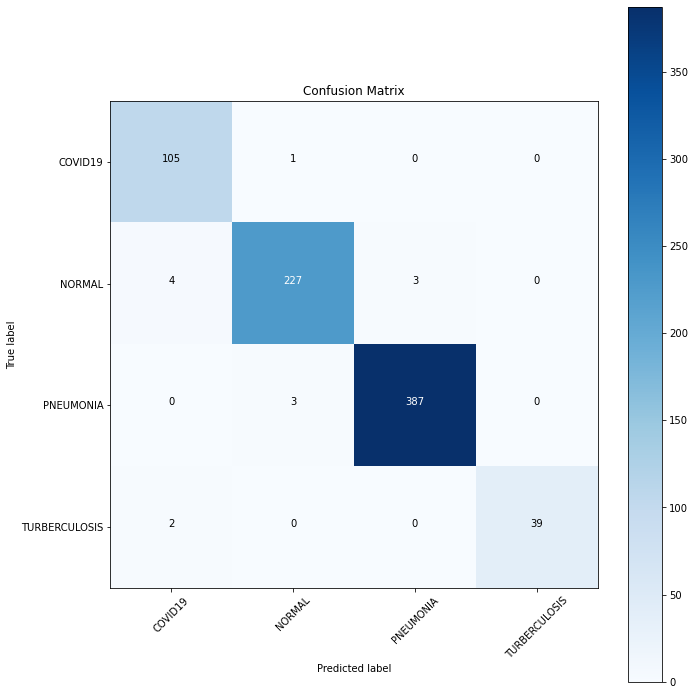

In [19]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = modeltrf.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [20]:
model_json = modeltrf.to_json()
with open("lungs_model.json", "w") as json_file:
    json_file.write(model_json)
modeltrf.save_weights("lungs_model.h5")
print("Model Saved to the disk")

Model Saved to the disk


In [21]:
from tensorflow.keras.preprocessing import image
def predict(img_name):
    img=image.load_img(img_name,target_size=(200,200))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    #img=tf.keras.applications.efficientnet.preprocess_input(img)
    prediction=modeltrf.predict(img.reshape(1,200,200,3))
    output=np.argmax(prediction)
    print(class_names[output])

In [22]:
import os
class_names=os.listdir('D:\input')
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA', 'test.zip', 'TURBERCULOSIS']
